In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# The token can be used to access the repository
!git clone https://github.com/cariello1/BIO-NER-.git

Cloning into 'BIO-NER-'...
remote: Enumerating objects: 496, done.
remote: Counting objects: 100% (131/131), done.
remote: Compressing objects: 100% (131/131), done.
remote: Total 496 (delta 76), reused 0 (delta 0), pack-reused 365
Receiving objects: 100% (496/496), 12.49 MiB | 22.16 MiB/s, done.
Resolving deltas: 100% (262/262), done.


In [ ]:
%cd /content/BIO-NER-

/content/BIO-NER-


In [ ]:
%%capture
!pip install tensorflow==2.3

In [ ]:
%%capture
import tensorflow as tf

In [ ]:
tf.__version__

'2.3.0'

In [ ]:
%%capture
# CRF layer for tensorflow 2 supportig keras masking
!pip install tf2crf

In [ ]:
from preprocessing_1 import PreprocessingDocsNN
from preprocessing_1 import read_data

# PREPROCESSING

In [ ]:
import numpy as np
import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette("Set3")
from matplotlib import pyplot as plt
from tqdm import tqdm
import random as rn

In [ ]:
# For reproducibility
seed = 937
np.random.seed(seed)
tf.compat.v1.set_random_seed(seed)

In [ ]:
# Original data in IOB format
file1 = "/content/drive/MyDrive/Data_Bio-NER/JNLPBA/original-data/train/Genia4ERtask1.iob2"
file2 = "/content/drive/MyDrive/Data_Bio-NER/JNLPBA/original-data/test/Genia4EReval1.iob2"

In [ ]:
input_train = read_data(file1)
input_test = read_data(file2)

Total number of sentences: 18546 
Total number of sentences: 3856 


In [ ]:
docs_train = PreprocessingDocsNN(input_train)
docs_test = PreprocessingDocsNN(input_test)

In [ ]:
# First sentence of train dataset with both words and labels
print('This is what a sentence looks like:{}'.format(input_train[0]))

This is what a sentence looks like:[('IL-2', 'B-DNA'), ('gene', 'I-DNA'), ('expression', 'O'), ('and', 'O'), ('NF-kappa', 'B-protein'), ('B', 'I-protein'), ('activation', 'O'), ('through', 'O'), ('CD28', 'B-protein'), ('requires', 'O'), ('reactive', 'O'), ('oxygen', 'O'), ('production', 'O'), ('by', 'O'), ('5-lipoxygenase', 'B-protein'), ('.', 'O')]


In [ ]:
print("\033[1m"+"Statistics for the train set:"+'\033[0m')
print("Number of sentences: {}".format(len(docs_train.sentences)))
print("Number of tokens: {}".format(len(docs_train.tokens)))
print("Size of vocabulary: {}".format(len(docs_train.vocabulary)))
print('Tagset:', ' '.join(docs_train.tagset))
print("Number of Tags {}".format(len(docs_train.tagset)))

Statistics for the train set:
Number of sentences: 18546
Number of tokens: 492551
Size of vocabulary: 22056
Tagset: B-RNA I-cell_line I-cell_type O I-RNA B-DNA B-cell_line I-DNA B-cell_type B-protein I-protein
Number of Tags 11


# DATA VISUALIZATION

In [ ]:
sentences_len = np.array([len(s) for s in docs_train.sentences]) #list with len for each sents

In [ ]:
#max_seq_len = np.round(sentences_len.mean()+sentences_len.std()).astype(int) #timesteps

In [ ]:
sen_mean = np.round(sentences_len.mean()).astype(int) 

In [ ]:
max_seq_len = 50 #timesteps

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


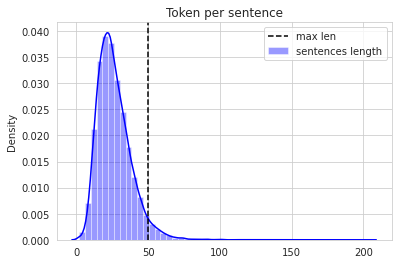

In [ ]:
sns.distplot(sentences_len, hist=True, kde=True, color="b", label="sentences length")
plt.axvline(x=max_seq_len, color="k", linestyle="--", label="max len")
plt.title("Token per sentence")
plt.legend()
plt.show()

In [ ]:
sent_less_than_msl = [s for s in docs_train.sentences if len(s) <= 50]
perc_sent = round(len(sent_less_than_msl) / len(docs_train.sentences) * 100)
print("The", perc_sent,"%", "of sentences has less or equal than 50 tokens.")

The 96 % of sentences has less or equal than 50 tokens.


# PREPROCESSING FOR TRAINING

Before feeding the data to the model we need to further preprocess the text. In order to feed the data to the Bi-LSTM model, we need to ensure that all text should be of the same length. The method sequence **pad_sequences()** and variable *max_seq_len* are used for this purpose. The text which are shorter than fixed *max_seq_len* value are padded to get them to the same length, whereas text which are longer than *max_seq_len* are truncated. Then, we use the **TextVectorization** layer from tf as text encoder. This allows to transforms a sequences of strings into a list of token indices. Every token in a sequence is mapped to a corresponding integer ID. This saves a lot of memory. 

In [ ]:
# Padding sentences to the max_seq_len
from keras.preprocessing.sequence import pad_sequences

X_train_padded = pad_sequences(maxlen=max_seq_len, sequences=docs_train.sentences, padding="post", value="", dtype=object, truncating = "post")
X_test_padded =  pad_sequences(maxlen=max_seq_len, sequences=docs_test.sentences, padding="post", value="", dtype=object, truncating = "post")

In [ ]:
X_test_padded[812]

array(['Finally', ',', 'DR3/', 'Wsl-1', 'protein', 'expression', 'is',
       'quite', 'variable', 'among', 'these', 'NB', 'cell', 'lines', ',',
       'with', 'very', 'low', 'or', 'undetectable', 'levels', 'in', '7',
       'of', '17', 'NB', 'cell', 'lines', '', '', '', '', '', '', '', '',
       '', '', '', '', '', '', '', '', '', '', '', '', '', ''],
      dtype=object)

In [ ]:
# Vocabulary Key:Tag -> Value:ID_tag & Vocabulary Key:ID_tag -> Value:Tag
tag2idx, idx2tag = docs_train.from_labels_2_idx()

In [ ]:
# Padding and encoding the target variable
y_train = docs_train.padded_and_encoded_labels(tag2idx, max_seq_len)
y_test = docs_test.padded_and_encoded_labels(tag2idx, max_seq_len)

In [ ]:
# Build the text encoder layer
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(split=None, standardize = None, ngrams=None,
    max_tokens=None, output_mode = "int")

In [ ]:
# Create the vocabulary
encoder.adapt(docs_train.tokens)

In [ ]:
# Extract the vocabulary
voc = np.array(encoder.get_vocabulary())

In [ ]:
# Explore first 30 more frequent words in the train set, first entry reserved for PAD
voc[:30] 

array(['', '[UNK]', 'of', 'the', '.', ',', 'and', 'in', 'to', ')', '(',
       'a', 'cells', 'that', 'by', 'with', 'is', 'expression', 'was',
       'cell', 'for', 'B', 'The', 'T', 'gene', 'human', 'activation',
       'transcription', 'protein', 'as'], dtype='<U48')

In [ ]:
# A dict mapping words to their IDs
word_index = dict(zip(voc, range(len(voc))))

In [ ]:
# A dict mapping IDs to their words
idx2word = {i: w for w, i in word_index.items()}

In [ ]:
len(word_index)

22058

In [ ]:
# Map padded sentences to integer IDs
X_train = encoder(np.array(X_train_padded))
X_test = encoder(np.array(X_test_padded))

In [ ]:
# Decoding in the test set; some words that are OOV are decoded as [UNK]
for n in range(3):
  print("Original: ", docs_test.sentences[n])
  print("Round-trip: ", " ".join(voc[X_test[n]]))
  print() 

Original:  ['Number', 'of', 'glucocorticoid', 'receptors', 'in', 'lymphocytes', 'and', 'their', 'sensitivity', 'to', 'hormone', 'action', '.']
Round-trip:  [UNK] of glucocorticoid receptors in lymphocytes and their sensitivity to hormone action .                                     

Original:  ['The', 'study', 'demonstrated', 'a', 'decreased', 'level', 'of', 'glucocorticoid', 'receptors', '(', 'GR', ')', 'in', 'peripheral', 'blood', 'lymphocytes', 'from', 'hypercholesterolemic', 'subjects', ',', 'and', 'an', 'elevated', 'level', 'in', 'patients', 'with', 'acute', 'myocardial', 'infarction', '.']
Round-trip:  The study demonstrated a decreased level of glucocorticoid receptors ( GR ) in peripheral blood lymphocytes from hypercholesterolemic subjects , and an elevated level in patients with acute myocardial infarction .                   

Original:  ['In', 'the', 'lymphocytes', 'with', 'a', 'high', 'GR', 'number', ',', 'dexamethasone', 'inhibited', '[', '3H', ']', '-thymidine', 'and', 

In [ ]:
print("The word 'cell' is identified by the index: {}".format(word_index["cell"]))
print("The labels 'B-DNA'(which defines the first token of a TERM) is identified by the index: {}".format(tag2idx["B-DNA"]))

The word 'cell' is identified by the index: 19
The labels 'B-DNA'(which defines the first token of a TERM) is identified by the index: 6


# IMPLEMENTING MODEL ARCHITECTURE

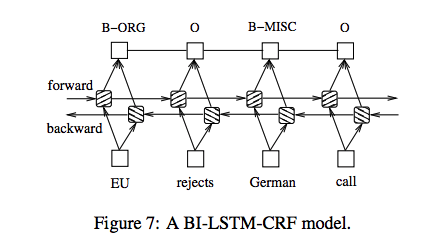


Model Architecture 

In [ ]:
# Hyperparams initialization
BATCH_SIZE = 32
EPOCHS = 10
EMBEDDING = 300

In [ ]:
# Separate about 10% of the sentences to get the validation set
X_train, X_val = X_train[:521 * BATCH_SIZE], X_train[-57 * BATCH_SIZE:]
y_train, y_val = y_train[:521 * BATCH_SIZE], y_train[-57 * BATCH_SIZE:]

In [ ]:
from keras.optimizers import SGD, Adam, RMSprop
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Input
from tf2crf import CRF, ModelWithCRFLoss
#from keras.layers import Masking

In [ ]:
# Model definition
def build_model(max_seq_len, opt=None):
  input = Input(shape=(max_seq_len,), dtype="int32") #timesteps
  #mask = Masking(mask_value=0)(input)
  model = Embedding(input_dim=len(word_index), output_dim=EMBEDDING,
                    input_length=max_seq_len, mask_zero = True)(input) 
  model = Bidirectional(LSTM(units=256, return_sequences=True,
                    recurrent_dropout=0.2))(model)
  model = Bidirectional(LSTM(units=125, return_sequences=True,
                    recurrent_dropout=0.2))(model)
  #dp = Dropout(0.4) (model) 
  out = (Dense(len(tag2idx), activation=None))(model)
  crf = CRF(dtype='float32') # CRF layer
  output = crf(out)
  base_model = Model(input, output)
  model = ModelWithCRFLoss(base_model)

  if opt:
    opt = opt
  else:
    opt = Adam()
  
  model.compile(optimizer=opt)
  print(base_model.summary())
  return model

In [ ]:
"""#try different optimizers

for OPTIMAZER in [SGD(), Adam(), RMSprop()]:
  print()
  model.compile(optimizer=OPTIMAZER, loss= crf_losses.crf_loss, metrics=[crf_accuracies.crf_viterbi_accuracy])
  model.fit(X_train, np.array(y_train), epochs=5, batch_size=32, verbose=1, validation_data=(X_val, np.array(y_val)))
  score = model.evaluate(X_test, np.array(y_test))
  print()
  print("OPTIMEZER: ", OPTIMAZER)
  print("\nTest score ", score[0])
  print("Test accuracy: ", score[1])"""

'#try different optimizers\n\nfor OPTIMAZER in [SGD(), Adam(), RMSprop()]:\n  print()\n  model.compile(optimizer=OPTIMAZER, loss= crf_losses.crf_loss, metrics=[crf_accuracies.crf_viterbi_accuracy])\n  model.fit(X_train, np.array(y_train), epochs=5, batch_size=32, verbose=1, validation_data=(X_val, np.array(y_val)))\n  score = model.evaluate(X_test, np.array(y_test))\n  print()\n  print("OPTIMEZER: ", OPTIMAZER)\n  print("\nTest score ", score[0])\n  print("Test accuracy: ", score[1])'

# TRAINING

In [ ]:
dir_output = "/content/drive/MyDrive/BIO-NER-project/bi-lstm-crf-JNLPBA.h5"

In [ ]:
# Early stopping stops the training process when val_loss is not improving
# ModelCkpt save only the best model (model with lowest val_loss)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
early_stopping = EarlyStopping(monitor="val_crf_loss_val", patience=2, restore_best_weights=True, verbose=1)
#model_save = ModelCheckpoint(dir_output, save_best_only=True, monitor='val_loss', mode='min', verbose=1)

In [ ]:
def ignoring_padding(y_pred,y_test):
  """This function allows to compare predicted labels with true labels discarding padding"""
  real_pred = []
  y_test_nozeroes = [[l for l in s if l != 0] for s in y_test] # Delete padding label in the original sentences
  for s, s1 in zip(y_pred, y_test_nozeroes):
    s = s.tolist() 
    real_s =  s[:len(s1)] # Delete padding from the predicted sentences
    real_pred.append(real_s)
  pred_tag = [[idx2tag[i] for i in row] for row in real_pred]
  y_test_tag = [[idx2tag[i] for i in row] for row in y_test_nozeroes]
  return pred_tag, y_test_tag

In [ ]:
%%capture
!pip3 install seqeval

In [ ]:
from keras.callbacks import Callback
from seqeval.metrics import f1_score

class Metrics(Callback):
    """Custom F1 metric to look after the performance on the validation set during the training"""
    def __init__(self, validation):   
        super(Metrics, self).__init__()
        self.validation = validation    
            
        print('validation shape', len(self.validation[0]))
        
    def on_train_begin(self, logs={}):        
        self.val_f1s = []
     
    def on_epoch_end(self, epoch, logs={}):
        val_targ = self.validation[1]   
        val_predict = self.model.predict(self.validation[0])[0]
        y_true, y_hat = ignoring_padding(val_predict, val_targ)
        val_f1 = f1_score(y_true, y_hat)
        
        
        self.val_f1s.append(round(val_f1, 6))
        
 
        print(f' — val_f1: {val_f1} ')

In [ ]:
# Customised callbacks
mycallbacks = [ early_stopping]

In [ ]:
model = build_model(max_seq_len, RMSprop())

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 50, 300)           6617400   
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 512)           1140736   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 50, 250)           638000    
_________________________________________________________________
dense (Dense)                (None, 50, 12)            3012      
_________________________________________________________________
crf (CRF)                    ((None, 50), (None, 50, 1 170       
Total params: 8,399,318
Trainable params: 8,399,316
Non-trainable params: 2
____________________________________________

In [ ]:
%%time
# Fit network - F1-score is measured on the validation data
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1, validation_data=(X_val, y_val), callbacks = mycallbacks)

Epoch 1/10
521/521 [==============================] - 159s 306ms/step - loss: 11.8014 - accuracy: 0.8604 - val_loss_val: 6.9046 - val_val_accuracy: 0.9024
Epoch 2/10
521/521 [==============================] - 157s 301ms/step - loss: 4.8476 - accuracy: 0.9250 - val_loss_val: 5.2008 - val_val_accuracy: 0.9146
Epoch 3/10
521/521 [==============================] - 157s 301ms/step - loss: 3.6255 - accuracy: 0.9361 - val_loss_val: 4.8523 - val_val_accuracy: 0.9130
Epoch 4/10
521/521 [==============================] - 157s 301ms/step - loss: 3.0266 - accuracy: 0.9427 - val_loss_val: 4.5302 - val_val_accuracy: 0.9154
Epoch 5/10
521/521 [==============================] - 161s 309ms/step - loss: 2.6073 - accuracy: 0.9484 - val_loss_val: 4.3767 - val_val_accuracy: 0.9178
Epoch 6/10
521/521 [==============================] - 158s 303ms/step - loss: 2.2889 - accuracy: 0.9525 - val_loss_val: 4.5849 - val_val_accuracy: 0.9159
Epoch 7/10
521/521 [==============================] - 158s 303ms/step - los

In [ ]:
#model.summary()

In [ ]:
model.save_weights(dir_output)

**Output** = viterbi_sequence, inputs(the output of the previous
layer), sequence_lengths (mask), self.transitions (crf transmission
parameters)

# LEARNING CURVES

In [ ]:
#history.history

In [ ]:
history.epoch

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [ ]:
epochs = len(history.epoch)
epochs = range(0,epochs)

In [ ]:
plt.rcParams["figure.figsize"] = [8,5]
loss_train = [9.7034, 3.7757, 2.7309, 2.1741, 1.8110, 1.5253]
loss_val = history.history["val_crf_loss_val"]
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='Validation loss')
plt.xticks(np.arange(0, len(epochs)))
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

KeyError: ignored

In [ ]:
plt.rcParams["figure.figsize"] = [8,5]
loss_train = history.history["accuracy"]
loss_val = history.history["val_val_accuracy"]
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='Validation accuracy')
plt.xticks(np.arange(1, len(epochs)+1))
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# PREDICTION AND EVALUATION

In [ ]:
#model = build_model(max_seq_len, RMSprop())

In [ ]:
dir_output

In [ ]:
#model.variables

In [ ]:
# This saves me
model.built = True 

In [ ]:
#model.load_weights("/content/drive/MyDrive/BIO-NER-project/bi-lstm-crf.h5")

In [ ]:
len(X_test)

3856

In [ ]:
X_test = X_test[:120*BATCH_SIZE]
y_test = y_test[:120*BATCH_SIZE]

In [ ]:
%%time
y_pred = model.predict(X_test)

CPU times: user 11.3 s, sys: 928 ms, total: 12.2 s
Wall time: 9.07 s


In [ ]:
len(y_pred)

3856

In [ ]:
y_hat, y_true = ignoring_padding(y_pred, y_test)

In [ ]:
!pip install nervaluate

In [ ]:
from nervaluate import Evaluator
golden_tags = ["protein", "cell_type", "cell_line", "DNA", "RNA"]
evaluator = Evaluator(y_true, y_hat, tags = golden_tags, loader="list")
results, results_by_tag = evaluator.evaluate()
import pandas as pd
res = pd.DataFrame.from_dict(results)

In [ ]:
res

,ent_type,partial,strict,exact
correct,6304.000000,5789.000000,5430.000000,5789.000000
incorrect,572.000000,0.000000,1446.000000,1087.000000
partial,0.000000,1087.000000,0.000000,0.000000
missed,1687.000000,1687.000000,1687.000000,1687.000000
spurious,1607.000000,1607.000000,1607.000000,1607.000000
possible,8563.000000,8563.000000,8563.000000,8563.000000
actual,8483.000000,8483.000000,8483.000000,8483.000000
precision,0.743133,0.746493,0.640104,0.682424
recall,0.736191,0.739519,0.634124,0.676048
f1,0.739646,0.742990,0.637100,0.679221


# REPORT

In [ ]:
from seqeval.metrics import classification_report

In [ ]:
print('\033[1m' + "Classification report for #1 model without LR optimization: ")
print('\033[0m')
print(classification_report(y_true, y_hat))

Classification report for #1 model without LR optimization: 

              precision    recall  f1-score   support

         DNA       0.60      0.61      0.60      1040
         RNA       0.68      0.68      0.68       117
   cell_line       0.45      0.53      0.48       496
   cell_type       0.75      0.60      0.66      1897
     protein       0.64      0.66      0.65      5013

   micro avg       0.64      0.63      0.64      8563
   macro avg       0.62      0.61      0.62      8563
weighted avg       0.65      0.63      0.64      8563



In [ ]:
print("F1-score(relaxed): {:0.3}".format(f1_score(y_true, y_hat, average = "weighted")))

In [ ]:
from seqeval.scheme import IOB2
print('\033[1m' + "Classification report for #1 model without LR optimization (exact match): ")
print('\033[0m')
print(classification_report(y_true, y_hat, scheme=IOB2, mode="strict"))

Classification report for #1 model without LR optimization (exact match): 

              precision    recall  f1-score   support

         DNA       0.60      0.61      0.60      1037
         RNA       0.69      0.68      0.68       117
   cell_line       0.45      0.53      0.49       495
   cell_type       0.75      0.60      0.66      1890
     protein       0.64      0.66      0.65      5008

   micro avg       0.64      0.64      0.64      8547
   macro avg       0.62      0.62      0.62      8547
weighted avg       0.65      0.64      0.64      8547



In [ ]:
print("F1-score: {:0.3}".format(f1_score(y_true, y_hat, average = "weighted", scheme=IOB2, mode="strict")))

F1-score: 0.64


# COMPARE RESULTS

In [ ]:
i = 18  #prendi il chunck di frasi da 390 a 390+32
p = model.predict(X_test[i:i+BATCH_SIZE])[0][0]
#p = np.argmax(p, axis=-1)

In [ ]:
# From tensor to array
X_true1 = tf.make_tensor_proto(X_test)
X_true1 = tf.make_ndarray(X_true1)

In [ ]:
print("{:15} {:5}: ({})".format("Word", "Pred", "True"))
print("="*45)
for w, true, pred in zip(X_true1[i], y_true[i], p):
    if w != 0:
      print("{:15}:{:15} ({})".format(idx2word[w], idx2tag[pred], true))

# EXPLORING EMBEDDING LAYER

In [ ]:
# Embeddings has a shape of (vocab_size, embedding_dim)
embeddings = model.layers[0].get_weights()[0] #embeddings

In [ ]:
# Explore dictionary
word_index.items()

In [ ]:
# Word2idx is a mapping (i.e. dict) from words to their index, e.g. "cell": 69
words_embeddings = {w:embeddings[idx] for w, idx in word_index.items()}

In [ ]:
print("What is the vector representation for the word 'cell'?")
#words_embeddings["cell"]

# TUNING LEARNING RATE

LRFinder implements a Keras Callback which tracks the loss associated with a learning rate varied linearly over a defined range. Implementation by https://github.com/WittmannF

In [ ]:
from lrfinder import LRFinder

In [ ]:
"""# Get an instance of LRTest class
lr_finder = LRFinder(min_lr=1e-4, max_lr=1)

# Build the model again
model2 = build_model(max_seq_len, RMSprop())

# Perform the LR range test 
history = model2.fit(X_train, np.array(y_train), epochs=10, batch_size=32, verbose=0, callbacks=[lr_finder])"""

# TRAIN THE MODEL WITH OPTIMAL LR

To avoid overfitting, it will be choose a learning rate that is a little futher than the optimal value.

In [ ]:
"""# Build the model with the optimal lr
model3 = build_model(max_seq_len, RMSprop(lr=10**-2.8))

# Train the model
model3.fit(X_train, y_train, epochs=5, batch_size=BATCH_SIZE, verbose=1, validation_data=(X_val, y_val), callbacks=mycallbacks)"""

In [ ]:
%%time
y_pred = model.predict(X_test)[0]

In [ ]:
y_hat, y_true = ignoring_padding(y_pred, y_test)

In [ ]:
print('\033[1m' + "Classification report for #2 model with LR optimization: ")
print('\033[0m')
print(classification_report(y_true, y_hat))

In [ ]:
print("F1-score(relaxed): {:0.3}".format(f1_score(y_true, y_hat, average = "weighted")))

In [ ]:
print('\033[1m' + "Classification report for #1 model without LR optimization (exact match): ")
print('\033[0m')
print(classification_report(y_true, y_hat, scheme=IOB2, mode="strict"))

In [ ]:
from seqeval.scheme import IOB2
print("F1-score: {:0.3}".format(f1_score(y_true, y_hat, average = "weighted", scheme=IOB2, mode="strict")))

In [ ]:
import sys

print('Saving classification report on file...')

original_stdout = sys.stdout 

with open('/content/drive/MyDrive/output.txt', 'a') as f:
  sys.stdout = f # Change the standard output to the file we created.
  print('\033[1m' + "Classification report Bi-LSTM+CRF for JNLPBA dataset: ")
  print('\033[0m')
  print(classification_report(y_true, y_hat))
  sys.stdout = original_stdout # Reset the standard output to its original value
print("Done.")